# Implementing Soft-Actor-Critic from original paper (2018)  
(https://arxiv.org/pdf/1801.01290.pdf)
### References: 
OpenAI Gym <br/>
https://github.com/vaishak2future/sac/blob/master/sac.ipynb <br/>
https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665

In [14]:
import simulation
import sys
import random
import pandas as pd
import importlib
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import torch.distributions as tdist

## Using Vaishak Kumar's implementation of version 1

In [15]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [16]:
class Space():
    def __init__(self, low, high, length, dtype):
        self.shape = (length)
        self.dtype = np.dtype(dtype)
        self.low = low
        self.high = high

class ActionSpace(Space):
    def __init__(self, low = 0, high = 10, length=24, dtype= np.float32):
        super().__init__(low, high, length, dtype)
    
    def sample(self):
        return np.random.uniform(self.low,self.high,self.shape)

class StateSpace(Space):
    def __init__(self, low = 0, high = 100, length=48, dtype= np.float32):
        super().__init__(low, high, length, dtype)

In [17]:
class NormalizedActions(ActionSpace):
    def __init__(self):
        self.action_space = ActionSpace()
        self.state_space = StateSpace()
        
    def _action(self, action):
        """
        Input: Action- a np_array of length= self.length (self refers to NormalizedActions)
        Returns: "normalized action"
        """
        low  = np.ones(self.length) * self.low
        high = np.ones(self.length) * self.high
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.low
        high = self.high
        action_prime = []
        for x in np.nditer(action):
            x_prime = 2*(x-low) / (high-low) - 1
            action_prime.append(x_prime)
        action_prime = np.array(action_prime)
        action_prime = np.clip(action_prime, low, high)
        
        return action_prime
    
    def step(self, office, price, controllers_points):
        end = False
        energy_dict = {}
        rewards_dict = {}
        # DO per person reward!!
        # Add per person to parameter ^^^^
        # Add i to the state 
        # or add map i: kwh_i, or reference yesterday player energy
        count = 0
        energy = None
        for player_name in office.players_dict:
            if(count < 1):
                player = office.players_dict.get(player_name)
                player_energy = player.threshold_exp_response(controllers_points)
                energy = player_energy
                last_player_energy = player_energy
                energy_dict[player_name] = player_energy

                player_min_demand = player.get_min_demand()
                player_max_demand = player.get_max_demand()
                player_reward = simulation.Reward(player_energy, price[0:24], player_min_demand, player_max_demand)
                player_ideal_demands = player_reward.ideal_use_calculation()
                last_player_ideal = player_ideal_demands
                reward = player_reward.scaled_cost_distance_neg(player_ideal_demands)
                rewards_dict[player_name] = reward
                count += 1
        
        total_reward = sum(rewards_dict.values())
        office._timestep = office._timestep + office._time_interval
        
        if office._timestep>office._end_timestamp:
            office._timestep = office._start_timestamp

        #Traininng on one day!
        diff = (office.get_timestep()-office._start_timestamp)
        next_price = price[0:24] #office.price_signal(diff.days + 1)
        next_state = np.concatenate([next_price, energy])
        return next_state, total_reward, end

In [18]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
#         print(state.shape)
#         print(action.shape)
        x = torch.cat([state, action],1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z = normal.sample() #.to(device)
        action = torch.sigmoid(mean+ std*z)
        #action = action.to(dtype = torch.int32)
#       log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = Normal(mean, std).log_prob(mean+ std*z) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_points(self, state):
        state = torch.FloatTensor(state).unsqueeze(0) #.to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z = normal.sample() #.to(device)
        action = torch.sigmoid(mean+ std*z)
        #action = action.to(dtype = torch.int32)
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

In [19]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state) #.to(device)
    next_state = torch.FloatTensor(next_state) #.to(device)
    action     = torch.FloatTensor(action) #.to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1) #.to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1) #.to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())


    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

In [20]:
env = NormalizedActions()

action_dim = env.action_space.shape
state_dim  = env.state_space.shape
hidden_dim = 32

value_net        = ValueNetwork(state_dim, hidden_dim) #.to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim) #.to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim) #.to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim) #.to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim) #.to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 10000


## Hyperparam

In [28]:
max_steps = 2000
batch_size = 25
value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

creating agents
creating controller
0 / 2000
1 / 2000
2 / 2000
3 / 2000
4 / 2000
5 / 2000
6 / 2000
7 / 2000
8 / 2000
9 / 2000
10 / 2000
11 / 2000
12 / 2000
13 / 2000
14 / 2000
15 / 2000
16 / 2000
17 / 2000
18 / 2000
19 / 2000
20 / 2000
21 / 2000
22 / 2000
23 / 2000
24 / 2000
25 / 2000
26 / 2000
27 / 2000
28 / 2000
29 / 2000
30 / 2000
31 / 2000
32 / 2000
33 / 2000
34 / 2000
35 / 2000
36 / 2000
37 / 2000
38 / 2000
39 / 2000
40 / 2000
41 / 2000
42 / 2000
43 / 2000
44 / 2000
45 / 2000
46 / 2000
47 / 2000
48 / 2000
49 / 2000
50 / 2000
51 / 2000
52 / 2000
53 / 2000
54 / 2000
55 / 2000
56 / 2000
57 / 2000
58 / 2000
59 / 2000
60 / 2000
61 / 2000
62 / 2000
63 / 2000
64 / 2000
65 / 2000
66 / 2000
67 / 2000
68 / 2000
69 / 2000
70 / 2000
71 / 2000
72 / 2000
73 / 2000
74 / 2000
75 / 2000
76 / 2000
77 / 2000
78 / 2000
79 / 2000
80 / 2000
81 / 2000
82 / 2000
83 / 2000
84 / 2000
85 / 2000
86 / 2000
87 / 2000
88 / 2000
89 / 2000
90 / 2000
91 / 2000
92 / 2000
93 / 2000
94 / 2000
95 / 2000
96 / 2000
97 /

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([150, 24])) that is different to the input size (torch.Size([150, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


152 / 2000
153 / 2000
154 / 2000
155 / 2000
156 / 2000
157 / 2000
158 / 2000
159 / 2000
160 / 2000
161 / 2000
162 / 2000
163 / 2000
164 / 2000
165 / 2000
166 / 2000
167 / 2000
168 / 2000
169 / 2000
170 / 2000
171 / 2000
172 / 2000
173 / 2000
174 / 2000
175 / 2000
176 / 2000
177 / 2000
178 / 2000
179 / 2000
180 / 2000
181 / 2000
182 / 2000
183 / 2000
184 / 2000
185 / 2000
186 / 2000
187 / 2000
188 / 2000
189 / 2000
190 / 2000
191 / 2000
192 / 2000
193 / 2000
194 / 2000
195 / 2000
196 / 2000
197 / 2000
198 / 2000
199 / 2000
200 / 2000
201 / 2000
202 / 2000
203 / 2000
204 / 2000
205 / 2000
206 / 2000
207 / 2000
208 / 2000
209 / 2000
210 / 2000
211 / 2000
212 / 2000
213 / 2000
214 / 2000
215 / 2000
216 / 2000
217 / 2000
218 / 2000
219 / 2000
220 / 2000
221 / 2000
222 / 2000
223 / 2000
224 / 2000
225 / 2000
226 / 2000
227 / 2000
228 / 2000
229 / 2000
230 / 2000
231 / 2000
232 / 2000
233 / 2000
234 / 2000
235 / 2000
236 / 2000
237 / 2000
238 / 2000
239 / 2000
240 / 2000
241 / 2000
242 / 2000

899 / 2000
900 / 2000
901 / 2000
902 / 2000
903 / 2000
904 / 2000
905 / 2000
906 / 2000
907 / 2000
908 / 2000
909 / 2000
910 / 2000
911 / 2000
912 / 2000
913 / 2000
914 / 2000
915 / 2000
916 / 2000
917 / 2000
918 / 2000
919 / 2000
920 / 2000
921 / 2000
922 / 2000
923 / 2000
924 / 2000
925 / 2000
926 / 2000
927 / 2000
928 / 2000
929 / 2000
930 / 2000
931 / 2000
932 / 2000
933 / 2000
934 / 2000
935 / 2000
936 / 2000
937 / 2000
938 / 2000
939 / 2000
940 / 2000
941 / 2000
942 / 2000
943 / 2000
944 / 2000
945 / 2000
946 / 2000
947 / 2000
948 / 2000
949 / 2000
950 / 2000
951 / 2000
952 / 2000
953 / 2000
954 / 2000
955 / 2000
956 / 2000
957 / 2000
958 / 2000
959 / 2000
960 / 2000
961 / 2000
962 / 2000
963 / 2000
964 / 2000
965 / 2000
966 / 2000
967 / 2000
968 / 2000
969 / 2000
970 / 2000
971 / 2000
972 / 2000
973 / 2000
974 / 2000
975 / 2000
976 / 2000
977 / 2000
978 / 2000
979 / 2000
980 / 2000
981 / 2000
982 / 2000
983 / 2000
984 / 2000
985 / 2000
986 / 2000
987 / 2000
988 / 2000
989 / 2000

1592 / 2000
1593 / 2000
1594 / 2000
1595 / 2000
1596 / 2000
1597 / 2000
1598 / 2000
1599 / 2000
1600 / 2000
1601 / 2000
1602 / 2000
1603 / 2000
1604 / 2000
1605 / 2000
1606 / 2000
1607 / 2000
1608 / 2000
1609 / 2000
1610 / 2000
1611 / 2000
1612 / 2000
1613 / 2000
1614 / 2000
1615 / 2000
1616 / 2000
1617 / 2000
1618 / 2000
1619 / 2000
1620 / 2000
1621 / 2000
1622 / 2000
1623 / 2000
1624 / 2000
1625 / 2000
1626 / 2000
1627 / 2000
1628 / 2000
1629 / 2000
1630 / 2000
1631 / 2000
1632 / 2000
1633 / 2000
1634 / 2000
1635 / 2000
1636 / 2000
1637 / 2000
1638 / 2000
1639 / 2000
1640 / 2000
1641 / 2000
1642 / 2000
1643 / 2000
1644 / 2000
1645 / 2000
1646 / 2000
1647 / 2000
1648 / 2000
1649 / 2000
1650 / 2000
1651 / 2000
1652 / 2000
1653 / 2000
1654 / 2000
1655 / 2000
1656 / 2000
1657 / 2000
1658 / 2000
1659 / 2000
1660 / 2000
1661 / 2000
1662 / 2000
1663 / 2000
1664 / 2000
1665 / 2000
1666 / 2000
1667 / 2000
1668 / 2000
1669 / 2000
1670 / 2000
1671 / 2000
1672 / 2000
1673 / 2000
1674 / 2000
1675

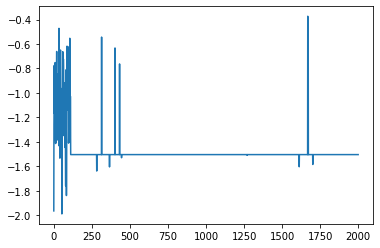

In [29]:
replay_buffer = ReplayBuffer(replay_buffer_size)
office = simulation.Office()
diff = (office.get_timestep()-office._start_timestamp)
state = np.concatenate([office.price_signal(diff.days + 50), np.zeros(24)])
rewards = []
action_star = None
for step in range(max_steps):
    print((str(step) + " / " + str(max_steps)))
    if step >110:
        action = policy_net.get_points(state).detach()
        next_state, reward, done = env.step(office, state, action.numpy())
    else:
        action = env.action_space.sample()
        next_state, reward, done = env.step(office, state, action) 
        #office.step -> returns reward, action, kwh, end
            # State = price for today and energy used yesterday(?)
            # need to add price to state
        
    action_star = action
    replay_buffer.push(state, action, reward, next_state, done)
        
    state = next_state
        
    if len(replay_buffer) > batch_size:
            update(batch_size)
        
    if done:
        break
        
    rewards.append(reward)

rewards = [r[0] if r is np.ndarray else r for r in rewards]
plt.plot(np.array(range(max_steps)),rewards)



tensor([1.1628e-10, 1.0429e-23, 2.6702e-09, 1.0199e-13, 5.1415e-11, 6.0793e-11,
        9.2752e-11, 1.2722e-10, 3.8782e-09, 3.5054e-12, 1.9880e-09, 5.7737e-11,
        6.2181e-12, 8.6660e-10, 7.4193e-11, 3.8268e-11, 6.6026e-11, 3.0655e-10,
        2.4185e-11, 5.2561e-11, 6.4888e-15, 2.1517e-10, 2.1731e-11, 8.8611e-11])
----
tensor([3.8782e-09, 3.5054e-12, 1.9880e-09, 5.7737e-11, 6.2181e-12, 8.6660e-10,
        7.4193e-11, 3.8268e-11, 6.6026e-11])


Text(0.5, 1.0, 'Price of Energy Today (SAC V1)')

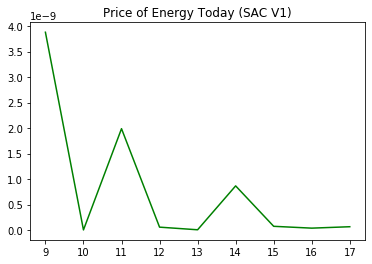

In [30]:
action_prime = action_star[8:17]
print(action_star)
print("----")
print(action_prime)
plt.plot(np.array([i for i in range(9,18)]),np.array(action_prime), color = 'green')
plt.title("Price of Energy Today (SAC V1)")

Text(0.5, 1.0, 'Rewards (SAC V1)')

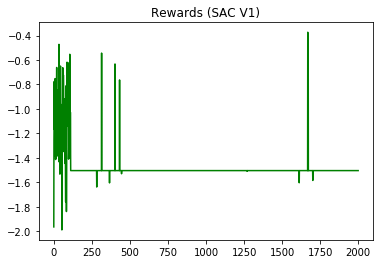

In [31]:
plt.plot(np.array(range(max_steps)),rewards, color='green')
plt.title("Rewards (SAC V1)")